In [46]:
import pandas as pd
import numpy as np
import re
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
from rapidfuzz import process, fuzz

In [2]:
cities = ['San Diego', 'Carlsbad', 'Chula Vista', 'Coronado', 'Del Mar',
                   'El Cajon', 'Encinitas', 'Escondido', 'Imperial Beach', 'La Mesa',
                   'Lemon Grove', 'National City', 'Oceanside', 'Poway', 'San Marcos',
                   'Santee', 'Solana Beach', 'Vista']
school_districts = ['Alpine Union Elementary', 'Bonsall Unified', 'Borrego Springs Unified', 'Cajon Valley Union',
                 'Cardiff Elementary', 'Carlsbad Unified', 'Chula Vista Elementary', 'Coronado Unified',
                 'Dehesa Elementary', 'Del Mar Union Elementary', 'Encinitas Union Elementary', 'Escondido Union',
                 'Escondido Union High', 'Fallbrook Union Elementary', 'Fallbrook Union High',
                 'Grossmont Union High', 'Jamul-Dulzura Union Elementary', 'Julian Union Elementary',
                 'Julian Union High', 'Lakeside Union Elementary-San Diego', 'La Mesa-Spring Valley',
                 'Lemon Grove School District', 'Mountain Empire Unified', 'National Elementary',
                 'Oceanside Unified', 'Poway Unified', 'Ramona City Unified', 'Rancho Santa Fe Elementary',
                 'San Diego County Office of Education', 'San Diego Unified', 'San Dieguito Union High',
                 'San Marcos Unified', 'San Pasqual Union Elementary', 'Santee School District',
                 'San Ysidro Elementary', 'Solana Beach Elementary', 'South Bay Union', 'Spencer Valley Elementary',
                 'Sweetwater Union High', 'Vallecitos Elementary', 'Valley Center-Pauma Unified', 'Vista Unified',
                 'Warner Unified']

In [134]:
# Load the provided CSV file
# Valid inputs for employer_type - ['cities', 'k12']
# Valid inputs for group - ['Police', 'Fire', 'Eng', None]
employer_type = 'cities'
group = None
file_path = f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/{employer_type}_sd_salaries.csv"
df = pd.read_csv(file_path, encoding='latin1')

df

C:\Users\Ericm\AppData\Local\Temp\ipykernel_10200\3267004863.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')


,Year,Agency,Employee Name,Job Title,Status,Base Pay,Overtime Pay,Other Pay,Total Pay,Benefits,Pension Debt,Total Pay & Benefits,0 annual pension debt payment,Notes
0,2011,Carlsbad,"Abalos, Constantine",Inspector II,NaN,72355.47,1147.96,540.0,74043.43,NaN,35400.98,109444.41,NaN,NaN
1,2011,Carlsbad,"Abbey, Raenette M.",Building Technician II,NaN,61114.22,0.00,0.0,61114.22,NaN,28937.04,90051.26,NaN,NaN
2,2011,Carlsbad,"Abbott, Cheri O.",Human Resources Manager,NaN,100357.89,3851.04,540.0,104748.93,NaN,44499.81,149248.74,NaN,NaN
3,2011,Carlsbad,"Abbott, Sandra L.",Human Resources Technician,NaN,58939.43,0.00,0.0,58939.43,NaN,19600.96,78540.39,NaN,NaN
4,2011,Carlsbad,"Acosta, June P.",GIS Administrator,NaN,91995.19,2756.27,0.0,94751.46,NaN,41013.94,135765.40,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284008,2023,San Diego,Cindy Juarez,Pump Station Operator,PT,0.00,0.00,16.0,16.00,0.0,0.00,16.00,NaN,NaN
284009,2023,San Diego,Alejandro Rodriguez-Carrillo,Utility Worker Ii,PT,0.00,0.00,10.0,10.00,0.0,0.00,10.00,NaN,NaN
284010,2023,San Diego,Jeffrey McCoy,Police Officer Ii,PT,0.00,0.00,8.0,8.00,0.0,0.00,8.00,NaN,NaN
284011,2023,San Diego,Trent Tkachuk,Water Utility Supervisor,PT,0.00,0.00,2.0,2.00,0.0,0.00,2.00,NaN,NaN


In [135]:
# Check for duplicates
duplicates = df.duplicated()

# Display the number of duplicate rows found
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows found: {num_duplicates}")
if num_duplicates > 0:
    # Remove duplicates
    df = df.drop_duplicates()
    df.to_csv(file_path, index=False)
    print(f"{num_duplicates} duplicate rows dropped")

Number of duplicate rows found: 0


In [137]:
#Adjust for inflation
cpi_df = pd.read_csv("C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts\SeriesReport-20240712171831_4c56aa.csv")
base_year_cpi = cpi_df['Annual'].iloc[15]
cpi_df['Inflation Index'] = 1 + (cpi_df['Annual'] - base_year_cpi) / base_year_cpi

cpi_df

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2,Inflation Index
0,2008,211.080,211.693,213.528,214.823,216.632,218.815,219.964,219.086,218.783,216.573,212.425,210.228,215.303,214.429,216.177,0.706602
1,2009,211.143,212.193,212.709,213.240,213.856,215.693,215.351,215.834,215.969,216.177,216.330,215.949,214.537,213.139,215.935,0.704088
2,2010,216.687,216.741,217.631,218.009,218.178,217.965,218.011,218.312,218.439,218.711,218.803,219.179,218.056,217.535,218.576,0.715637
3,2011,220.223,221.309,223.467,224.906,225.964,225.722,225.922,226.545,226.889,226.421,226.230,225.672,224.939,223.598,226.280,0.738226
4,2012,226.665,227.663,229.392,230.085,229.815,229.478,229.104,230.379,231.407,231.317,230.221,229.601,229.594,228.850,230.338,0.753503
5,2013,230.280,232.166,232.773,232.531,232.945,233.504,233.596,233.877,234.149,233.546,233.069,233.049,232.957,232.366,233.548,0.764540
6,2014,233.916,234.781,236.293,237.072,237.900,238.343,238.250,237.852,238.031,237.433,236.151,234.812,236.736,236.384,237.088,0.776943
7,2015,233.707,234.722,236.119,236.599,237.805,238.638,238.654,238.316,237.945,237.838,237.336,236.525,237.017,236.265,237.769,0.777865
8,2016,236.916,237.111,238.132,239.261,240.229,241.018,240.628,240.849,241.428,241.729,241.353,241.432,240.007,238.778,241.237,0.787678
9,2017,242.839,243.603,243.801,244.524,244.733,244.955,244.786,245.519,246.819,246.663,246.669,246.524,245.120,244.076,246.163,0.804458


In [138]:
df = pd.merge(df, cpi_df[['Year', 'Inflation Index']],on='Year', how='left')
numIndices = len(df)

df

,Year,Agency,Employee Name,Job Title,Status,Base Pay,Overtime Pay,Other Pay,Total Pay,Benefits,Pension Debt,Total Pay & Benefits,0 annual pension debt payment,Notes,Inflation Index
0,2011,Carlsbad,"Abalos, Constantine",Inspector II,NaN,72355.47,1147.96,540.0,74043.43,NaN,35400.98,109444.41,NaN,NaN,0.738226
1,2011,Carlsbad,"Abbey, Raenette M.",Building Technician II,NaN,61114.22,0.00,0.0,61114.22,NaN,28937.04,90051.26,NaN,NaN,0.738226
2,2011,Carlsbad,"Abbott, Cheri O.",Human Resources Manager,NaN,100357.89,3851.04,540.0,104748.93,NaN,44499.81,149248.74,NaN,NaN,0.738226
3,2011,Carlsbad,"Abbott, Sandra L.",Human Resources Technician,NaN,58939.43,0.00,0.0,58939.43,NaN,19600.96,78540.39,NaN,NaN,0.738226
4,2011,Carlsbad,"Acosta, June P.",GIS Administrator,NaN,91995.19,2756.27,0.0,94751.46,NaN,41013.94,135765.40,NaN,NaN,0.738226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284008,2023,San Diego,Cindy Juarez,Pump Station Operator,PT,0.00,0.00,16.0,16.00,0.0,0.00,16.00,NaN,NaN,1.000000
284009,2023,San Diego,Alejandro Rodriguez-Carrillo,Utility Worker Ii,PT,0.00,0.00,10.0,10.00,0.0,0.00,10.00,NaN,NaN,1.000000
284010,2023,San Diego,Jeffrey McCoy,Police Officer Ii,PT,0.00,0.00,8.0,8.00,0.0,0.00,8.00,NaN,NaN,1.000000
284011,2023,San Diego,Trent Tkachuk,Water Utility Supervisor,PT,0.00,0.00,2.0,2.00,0.0,0.00,2.00,NaN,NaN,1.000000


In [139]:
# Define a function to determine 'FT or PT' status
def determine_ft_or_pt(row):
    if pd.isna(row['Status']) == True or row['Status'] == None:
        if 0 < row['Base Pay'] < 30000:
            return 'PT'
        elif row['Base Pay'] >= 30000:
            return 'FT'
        else:
            return pd.NA

# Apply the function to each row to create the 'FT or PT' column
df['Status'] = df.apply(determine_ft_or_pt, axis=1)

# Display the updated DataFrame
df

,Year,Agency,Employee Name,Job Title,Status,Base Pay,Overtime Pay,Other Pay,Total Pay,Benefits,Pension Debt,Total Pay & Benefits,0 annual pension debt payment,Notes,Inflation Index
0,2011,Carlsbad,"Abalos, Constantine",Inspector II,FT,72355.47,1147.96,540.0,74043.43,NaN,35400.98,109444.41,NaN,NaN,0.738226
1,2011,Carlsbad,"Abbey, Raenette M.",Building Technician II,FT,61114.22,0.00,0.0,61114.22,NaN,28937.04,90051.26,NaN,NaN,0.738226
2,2011,Carlsbad,"Abbott, Cheri O.",Human Resources Manager,FT,100357.89,3851.04,540.0,104748.93,NaN,44499.81,149248.74,NaN,NaN,0.738226
3,2011,Carlsbad,"Abbott, Sandra L.",Human Resources Technician,FT,58939.43,0.00,0.0,58939.43,NaN,19600.96,78540.39,NaN,NaN,0.738226
4,2011,Carlsbad,"Acosta, June P.",GIS Administrator,FT,91995.19,2756.27,0.0,94751.46,NaN,41013.94,135765.40,NaN,NaN,0.738226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284008,2023,San Diego,Cindy Juarez,Pump Station Operator,None,0.00,0.00,16.0,16.00,0.0,0.00,16.00,NaN,NaN,1.000000
284009,2023,San Diego,Alejandro Rodriguez-Carrillo,Utility Worker Ii,None,0.00,0.00,10.0,10.00,0.0,0.00,10.00,NaN,NaN,1.000000
284010,2023,San Diego,Jeffrey McCoy,Police Officer Ii,None,0.00,0.00,8.0,8.00,0.0,0.00,8.00,NaN,NaN,1.000000
284011,2023,San Diego,Trent Tkachuk,Water Utility Supervisor,None,0.00,0.00,2.0,2.00,0.0,0.00,2.00,NaN,NaN,1.000000


In [140]:
def normalize_name(name):
    name = name.strip()

    # Check if the name is already in "Lastname, Firstname Middlename/Initial" format
    if "," in name:
        return name.title()  # Capitalize the entire string appropriately

    # Split the name into parts
    parts = name.split()

    if len(parts) == 1:
        # If there's only one part, it's just a last name, so we return it as is
        return name.title()

    if len(parts) == 2:
        # If there are two parts, assume it's "Firstname Lastname"
        firstname, lastname = parts
        return f"{lastname.title()}, {firstname.title()}"

    # If there are three or more parts
    firstname = parts[0].title()
    lastname = parts[-1].title()
    middle = " ".join([part.title() for part in parts[1:-1]])  # Capitalize each part of the middle names/initials
    return f"{lastname}, {firstname} {middle}"


df['Employee Name'] = df['Employee Name'].apply(normalize_name)

# Split the normalized names into 'Last', 'First', and 'Middle' components
split_names = df['Employee Name'].str.split(', ', expand=True)
df['Last'] = split_names[0]

# Check if 'First_Middle' exists before assigning
if split_names.shape[1] > 1:
    df['First_Middle'] = split_names[1]
else:
    df['First_Middle'] = ''

# Further split 'First_Middle' into 'First' and 'Middle'
split_first_middle = df['First_Middle'].str.split(' ', expand=True)
df['First'] = split_first_middle[0]

# Check if 'Middle' exists before assigning
if split_first_middle.shape[1] > 1:
    df['Middle'] = split_first_middle[1]
else:
    df['Middle'] = ''


def remove_suffix(lastname):
    parts = lastname.split(' ')

    # List of common suffixes
    suffixes = ['Jr', 'Sr', 'I', 'II', 'III', 'IV', 'V']

    # Check if the last part of the lastname is a suffix and remove it
    if len(parts) > 1 and parts[-1].title() in suffixes:
        return " ".join(parts[:-1])  # Return the lastname without the suffix

    return lastname


# Function to handle conflicts with middle initials
def resolve_middle_names(group):
    # Check if there are multiple entries for the same year with 'FT' status
    full_time_same_year = group[(group['Status'] == 'FT')].groupby('Year').size() > 1

    if len(group) == 1 or full_time_same_year.any():
        return group  # Only one name, nothing to change

    # Identify the different middle names
    unique_middle_names = group['Middle'].dropna().unique()

    if len(unique_middle_names) == 1:
        # If there's only one unique middle name, remove it unless they are working FT in the same year
        group['Middle'] = pd.NA
    return group


df['Last'] = df['Last'].apply(remove_suffix)

# Group by first and last name, and apply the function
df = df.groupby(['Last', 'First']).apply(resolve_middle_names).reset_index(drop=True)

# Reconstruct the full name with or without middle names
df['Employee Name'] = df.apply(
    lambda x: f"{x['Last']}, {x['First']} {x['Middle']}".strip() if pd.notna(x['Middle']) and x[
        'Middle'] else f"{x['Last']}, {x['First']}", axis=1)

# Drop temporary columns
df = df.drop(columns=['Last', 'First_Middle', 'First', 'Middle'])

df

C:\Users\Ericm\AppData\Local\Temp\ipykernel_10200\2712392263.py:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['Last', 'First']).apply(resolve_middle_names).reset_index(drop=True)


,Year,Agency,Employee Name,Job Title,Status,Base Pay,Overtime Pay,Other Pay,Total Pay,Benefits,Pension Debt,Total Pay & Benefits,0 annual pension debt payment,Notes,Inflation Index
0,2020,Escondido,"6255, Gc",Police Sergeant,FT,145998.0,17900.00,1711.00,165609.00,NaN,33352.00,41484.31,NaN,240445.31,0.849391
1,2020,Escondido,"6255, Gc",Police Officer,FT,110080.0,43814.00,7093.00,160987.00,NaN,38629.00,33535.36,NaN,233151.36,0.849391
2,2020,Escondido,"6255, Gc",Police Sergeant,FT,141048.0,9253.00,3654.00,153955.00,NaN,32191.00,39706.48,NaN,225852.48,0.849391
3,2020,Escondido,"6255, Gc",Police Officer,FT,104113.0,27278.00,6709.00,138100.00,NaN,39959.00,35962.46,NaN,214021.46,0.849391
4,2020,Escondido,"6255, Gc",Police Officer,FT,111949.0,30590.00,1333.00,143872.00,NaN,37753.00,32193.95,NaN,213818.95,0.849391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283252,2019,San Diego,"Zynn, Megan",Dispatcher 2,None,49632.0,3329.00,19439.00,72400.00,13780.00,NaN,86180.00,NaN,NaN,0.839039
283253,2020,San Diego,"Zynn, Megan",Dispatcher 2,None,50498.0,1636.00,18401.00,70535.00,13943.00,NaN,84478.00,NaN,NaN,0.849391
283254,2021,San Diego,"Zynn, Megan",Dispatcher Ii,None,49327.0,2275.00,19116.00,70718.00,14511.00,0.00,85229.00,NaN,NaN,0.889295
283255,2022,San Diego,"Zynn, Megan",Dispatcher Ii,None,58052.8,2530.81,32610.33,93193.94,15681.86,14076.01,122951.81,NaN,NaN,0.960463


In [143]:
# Job title standardization for police
standard_titles = [
    'POLICE OFFICER', 'Peace Officer', 'POLICE DISPATCHER', 'POLICE SERGEANT',
    'POLICE RECRUIT', 'POLICE CORPORAL', 'POLICE DETECTIVE',
    'POLICE RECORDS CLERK', 'POLICE SERVICES SPEC', 'POLICE CHIEF',
    'POLICE LIEUTENANT', 'POLICE CAPTAIN', 'ASSISTANT POLICE CHIEF',
    'POLICE PROPERTY AND EVIDENCE SPEC', 'POLICE RECORDS SPEC',
    'POLICE SERVICES OFFICER', 'POLICE DISPATCH SUPERVISOR',
    'POLICE RECORDS SUPERVISOR', 'POLICE COMMANDER',
    'POLICE TECHNOLOGY SPEC', 'POLICE SERVICES MANAGER',
    'POLICE TRAINING COORDINATOR', 'RESERVE POLICE OFFICER', 'POLICE AGENT',
    'Police Investigative Service Officer'
]

def match_title(title):
    best_match, score, i = process.extractOne(title, standard_titles, scorer=fuzz.WRatio)
    if score > 90:
        return best_match.title()
    else:
        return title.title()
    
position_match_dict = {}

unique_positions = df['Job Title'].unique()

for indiv_position in unique_positions:
            # Find the best match for each unique position
            position_match_dict[indiv_position] = match_title(indiv_position)
            
position_match_dict

{'Police Sergeant': 'Police Sergeant',
 'Police Officer': 'Police Officer',
 'Council Representative I': 'Council Representative I',
 'Fire Fighter Ii': 'Fire Fighter Ii',
 'Recreation Aide': 'Recreation Aide',
 'Management Intern': 'Management Intern',
 'Laboratory Technician': 'Laboratory Technician',
 'Police Dispatcher': 'Police Dispatcher',
 'Police Officer Ii': 'Police Officer Ii',
 'Librarian I': 'Librarian I',
 'Pool Guard 1': 'Pool Guard 1',
 'Lifeguard 1': 'Lifeguard 1',
 'Lifeguard I': 'Lifeguard I',
 'Seasonal Temp': 'Seasonal Temp',
 'Hr Technician - Uf': 'Hr Technician - Uf',
 'Senior Human Resources Technician': 'Senior Human Resources Technician',
 'Sr. Hr Technician': 'Sr. Hr Technician',
 'HR Technician - UF': 'Hr Technician - Uf',
 'Deputy City Atty': 'Deputy City Atty',
 'Deputy City Attorney': 'Deputy City Attorney',
 'Library Assistant': 'Library Assistant',
 'Library Assistant 3': 'Library Assistant 3',
 'Library Assistant Iii': 'Library Assistant Iii',
 'Profess

In [144]:
df['Job Title'] = df['Job Title'].map(position_match_dict)

In [145]:
df.to_csv(f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/sdcounty_salaries_cleaned.csv", index=False)

In [146]:
for column in df.columns[5:-1]:
    df[f'Adjusted {column}'] = df[column] / df['Inflation Index']

df

,Year,Agency,Employee Name,Job Title,Status,Base Pay,Overtime Pay,Other Pay,Total Pay,Benefits,...,Adjusted Base Pay,Adjusted Overtime Pay,Adjusted Other Pay,Adjusted Total Pay,Adjusted Benefits,Adjusted Pension Debt,Adjusted Total Pay & Benefits,Adjusted 0 annual pension debt payment,Adjusted Notes,Adjusted Inflation Index
0,2020,Escondido,"6255, Gc",Police Sergeant,FT,145998.0,17900.00,1711.00,165609.00,NaN,...,171885.594492,21073.933488,2014.385486,194973.913466,NaN,39265.800542,48840.088812,NaN,283079.802820,1.0
1,2020,Escondido,"6255, Gc",Police Officer,FT,110080.0,43814.00,7093.00,160987.00,NaN,...,129598.804378,51582.867142,8350.693309,189532.364830,NaN,45478.490319,39481.672969,NaN,274492.528118,1.0
2,2020,Escondido,"6255, Gc",Police Sergeant,FT,141048.0,9253.00,3654.00,153955.00,NaN,...,166057.886628,10893.693104,4301.907987,181253.487719,NaN,37898.938152,46747.023384,NaN,265899.449254,1.0
3,2020,Escondido,"6255, Gc",Police Officer,FT,104113.0,27278.00,6709.00,138100.00,NaN,...,122573.767444,32114.790932,7898.604457,162587.162833,NaN,47044.318897,42339.133526,NaN,251970.615256,1.0
4,2020,Escondido,"6255, Gc",Police Officer,FT,111949.0,30590.00,1333.00,143872.00,NaN,...,131799.205590,36014.057285,1569.360522,169382.623397,NaN,44447.162624,37902.411230,NaN,251732.197252,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283252,2019,San Diego,"Zynn, Megan",Dispatcher 2,None,49632.0,3329.00,19439.00,72400.00,13780.00,...,59153.356505,3967.632249,23168.159597,86289.148351,16423.542324,NaN,102712.690675,NaN,NaN,1.0
283253,2020,San Diego,"Zynn, Megan",Dispatcher 2,None,50498.0,1636.00,18401.00,70535.00,13943.00,...,59452.038731,1926.086882,21663.768163,83041.893776,16415.299141,NaN,99457.192917,NaN,NaN,1.0
283254,2021,San Diego,"Zynn, Megan",Dispatcher Ii,None,49327.0,2275.00,19116.00,70718.00,14511.00,...,55467.526125,2558.205890,21495.676392,79521.408407,16317.417877,0.000000,95838.826283,NaN,NaN,1.0
283255,2022,San Diego,"Zynn, Megan",Dispatcher Ii,None,58052.8,2530.81,32610.33,93193.94,15681.86,...,60442.515131,2634.989556,33952.718292,97030.222979,16327.396100,14655.442070,128013.061149,NaN,NaN,1.0


In [148]:
filtered_df = df[~df['Employee Name'].isin(['Provided, Not', 'Redacted'])]

# Sort by Name and Year to ensure we can track movements sequentially
filtered_df = filtered_df.sort_values(by=['Employee Name', 'Year', 'Agency'])

# List to store names that meet the criteria
selected_names = set()

# Group by Name to analyze movements and pay changes
for name, group in filtered_df.groupby('Employee Name'):
    # Sort the group by Year to track movements sequentially
    group = group.sort_values(by='Year')
    
    # Track the previous city and average total pay
    prev_city = None
    prev_avg_pay = None
    prev_ft_exists = False
    prev_pt_exists = False
    
    for i, row in group.iterrows():
        current_city = row['Agency']
        current_ft_exists = group[(group['Agency'] == current_city) & (group['Status'] == 'FT')]['Adjusted Base Pay'].count() > 0
        current_pt_exists = group[(group['Agency'] == current_city) & (group['Status'] == 'PT')]['Adjusted Base Pay'].count() > 0
        
        if prev_city is not None and current_city != prev_city:
            if prev_ft_exists and current_ft_exists:
                # Compare FT average wage
                prev_city_avg_pay = group[(group['Agency'] == prev_city) & (group['Status'] == 'FT')]['Adjusted Base Pay'].mean()
                current_city_avg_pay = group[(group['Agency'] == current_city) & (group['Status'] == 'FT')]['Adjusted Base Pay'].mean()
            elif prev_pt_exists and current_pt_exists:
                # Compare PT average wage
                prev_city_avg_pay = group[(group['Agency'] == prev_city) & (group['Status'] == 'PT')]['Adjusted Base Pay'].mean()
                current_city_avg_pay = group[(group['Agency'] == current_city) & (group['Status'] == 'PT')]['Adjusted Base Pay'].mean()
            else:
                # If neither FT nor PT is available in both cities, continue to the next person
                continue
            
            # Add the name to the set if the average pay in the new city is higher than in the previous city
            if current_city_avg_pay > prev_city_avg_pay:
                selected_names.add(name)
        
        # Update the previous city and flags for the next iteration
        prev_city = current_city
        prev_ft_exists = current_ft_exists
        prev_pt_exists = current_pt_exists

# Filter the original DataFrame to include all entries for the selected names
filtered_movements_df = filtered_df[filtered_df['Employee Name'].isin(selected_names)]

print('# of Movements: ', filtered_movements_df['Employee Name'].nunique())

filtered_movements_df

# of Movements:  1265


,Year,Agency,Employee Name,Job Title,Status,Base Pay,Overtime Pay,Other Pay,Total Pay,Benefits,...,Adjusted Base Pay,Adjusted Overtime Pay,Adjusted Other Pay,Adjusted Total Pay,Adjusted Benefits,Adjusted Pension Debt,Adjusted Total Pay & Benefits,Adjusted 0 annual pension debt payment,Adjusted Notes,Adjusted Inflation Index
107,2013,Encinitas,"Abalos, Jennifer",Human Resources Analyst Ii,PT,1270.54,0.00,0.91,1271.45,NaN,...,1661.834927,0.000000,1.190258,1663.025184,NaN,322.232793,1985.257977,NaN,NaN,1.0
108,2014,Encinitas,"Abalos, Jennifer",Human Resources Analyst Ii,FT,75357.88,0.00,5681.02,81038.90,NaN,...,96992.839077,0.000000,7312.019110,104304.858187,NaN,28411.785701,132716.643888,NaN,NaN,1.0
95,2015,Chula Vista,"Abalos, Jennifer",Sr Hr Analyst,PT,29704.14,0.00,0.00,29704.14,NaN,...,38186.758192,0.000000,0.000000,38186.758192,NaN,13124.257955,51311.016147,NaN,NaN,1.0
109,2015,Encinitas,"Abalos, Jennifer",Not Provided,FT,44097.24,761.67,7891.23,52750.14,NaN,...,56690.099117,979.180280,10144.730393,67814.009790,NaN,16060.706060,83874.715849,NaN,NaN,1.0
96,2016,Chula Vista,"Abalos, Jennifer",Sr Hr Analyst,FT,88196.00,0.00,10870.00,99066.00,NaN,...,111969.640852,0.000000,13800.058915,125769.699767,NaN,34931.795864,160701.495631,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282671,2016,Chula Vista,"Zimmer, Christopher",Peace Officer,FT,85992.00,9578.00,4860.00,100430.00,NaN,...,109171.542430,12159.794323,6170.035541,127501.372293,NaN,58973.352044,186474.724337,NaN,NaN,1.0
282672,2017,Chula Vista,"Zimmer, Christopher",Peace Officer,FT,90253.00,14148.00,4780.00,109181.00,NaN,...,112191.047675,17586.993701,5941.887892,135719.929267,NaN,62487.130600,198207.059867,NaN,NaN,1.0
282673,2018,Chula Vista,"Zimmer, Christopher",Peace Officer,FT,92612.00,36714.00,5484.00,134810.00,NaN,...,112378.633905,44550.049294,6654.477048,163583.160246,NaN,44311.002616,19919.698949,NaN,227813.861812,1.0
282674,2019,Chula Vista,"Zimmer, Christopher",Police Agent,FT,100275.00,23711.00,8110.00,132096.00,NaN,...,119511.662305,28259.696085,9665.814822,157437.173213,NaN,47538.884811,27225.048674,NaN,232201.106697,1.0


In [149]:
filtered_movements_df.to_csv(f'C:/Users/Ericm/PycharmProjects/wageData/.venv/Scripts/sdcounty_salaries_names_movements.csv', index=False)

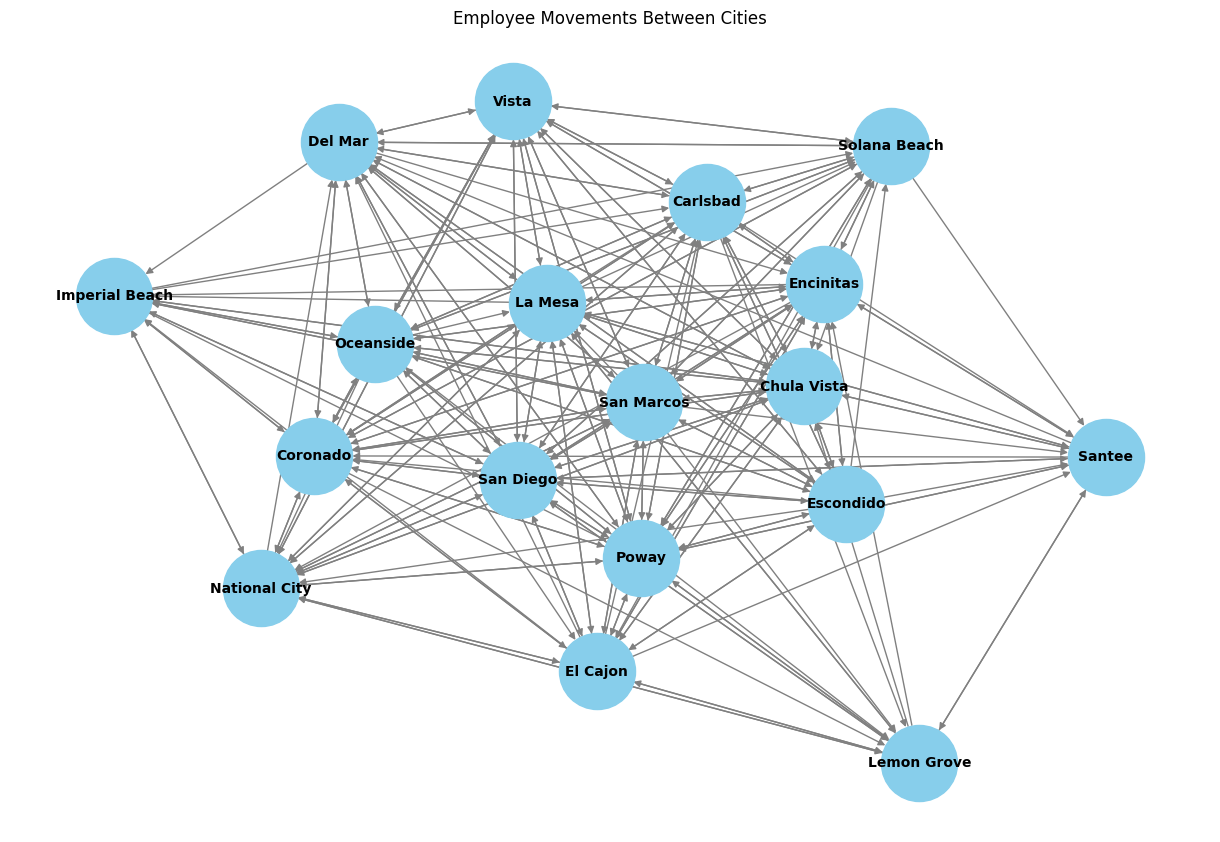

In [150]:
# Create an empty directed graph
G = nx.DiGraph()

# Add edges between cities for each individual who has worked in multiple cities
for name, group in filtered_movements_df.groupby('Employee Name'):
    cities = group['Agency'].unique()
    if len(cities) > 1:
        for i in range(len(cities) - 1):
            G.add_edge(cities[i], cities[i + 1])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
plt.title("Employee Movements Between Cities")

plt.savefig(f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/sdcounty_movement.pdf", bbox_inches='tight')
plt.show()


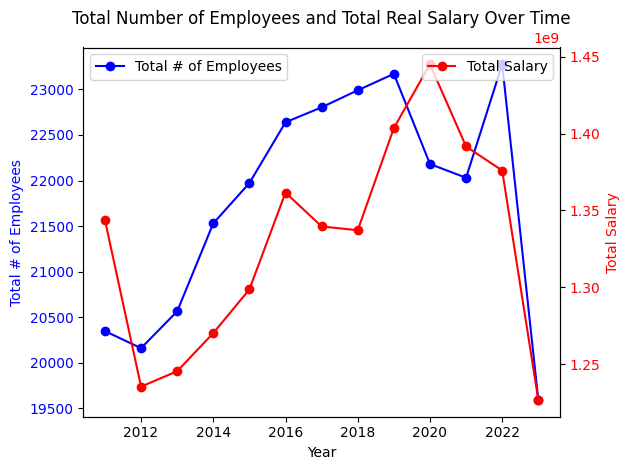

In [152]:
# Group by 'Year' to calculate total number of employees and total aggregate salary
yearly_data = df.groupby('Year').agg(
    total_employees=('Employee Name', 'count'),  # Count of rows per year (total employees)
    total_salary=('Adjusted Base Pay', 'sum')  # Sum of 'Regular pay' per year (total salary)
).reset_index()

# Plotting the data
fig, ax1= plt.subplots()

# Plot total number of employees on the first axis
ax1.plot(yearly_data['Year'], yearly_data['total_employees'], color='blue', marker='o', label='Total # of Employees')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total # of Employees', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot total salary on the second axis
ax2 = ax1.twinx()
ax2.plot(yearly_data['Year'], yearly_data['total_salary'], color='red', marker='o', label='Total Salary')
ax2.set_ylabel('Total Salary', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding a title
plt.title(f'Total Number of Employees and Total Real Salary Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show plot with legends
fig.tight_layout()  # Adjust layout to prevent overlap


plt.savefig(f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/sdcounty_salary_num_empls.pdf", bbox_inches='tight')

plt.show()

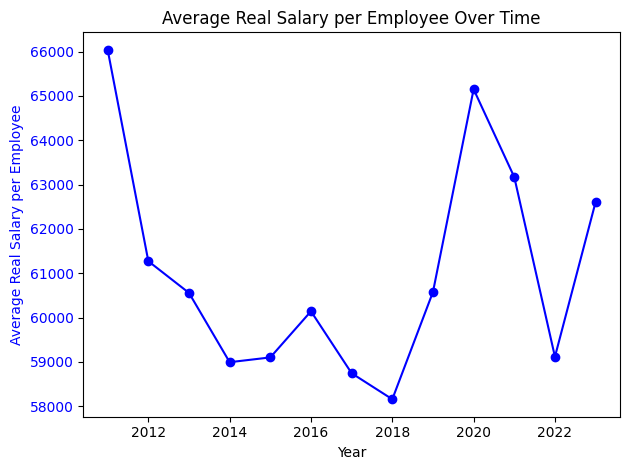

In [153]:
# Group by 'Year' to calculate total number of employees and total aggregate salary
yearly_data = df.groupby('Year').agg(
    total_employees=('Employee Name', 'count'),  # Count of rows per year (total employees)
    total_salary=('Adjusted Base Pay', 'sum')  # Sum of 'Regular pay' per year (total salary)
).reset_index()

# Plotting the data
fig, ax1 = plt.subplots()

# Plot total number of employees on the first axis
ax1.plot(yearly_data['Year'], yearly_data['total_salary']/yearly_data['total_employees'], color='blue', marker='o')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Real Salary per Employee', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Adding a title
plt.title(f'Average Real Salary per Employee Over Time')

# Show plot with legends
fig.tight_layout()  # Adjust layout to prevent overlap

plt.savefig(f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/sdcounty_avg_salary", bbox_inches='tight')

plt.show()

In [155]:
grouped_df = df.groupby(['Year', 'Agency']).agg(
    PositionCount=('Job Title', 'size'),
    MedianWages=('Adjusted Base Pay', 'median')
).reset_index()

grouped_df.columns = ['Year', 'Agency', 'NumEmpls', 'AdjMedWage']
grouped_df

,Year,Agency,NumEmpls,AdjMedWage
0,2011,Carlsbad,1190,60793.541219
1,2011,Chula Vista,1271,77443.309241
2,2011,Coronado,592,16765.660684
3,2011,El Cajon,568,76755.796390
4,2011,Encinitas,363,83647.803191
...,...,...,...,...
216,2023,El Cajon,548,70161.500000
217,2023,Encinitas,432,62967.000000
218,2023,Escondido,1171,51593.000000
219,2023,Oceanside,1456,58842.000000


In [156]:
grouped_df['NumEmpls%Chg'] = grouped_df.groupby(['Agency'])['NumEmpls'].pct_change()
grouped_df['AdjMedWage%Chg'] = grouped_df.groupby(['Agency'])['AdjMedWage'].pct_change()

#grouped_df.to_csv(f"C:/Users/Ericm\PycharmProjects\wageData\.venv\Scripts/{position}_RoC.csv")

grouped_df

,Year,Agency,NumEmpls,AdjMedWage,NumEmpls%Chg,AdjMedWage%Chg
0,2011,Carlsbad,1190,60793.541219,NaN,NaN
1,2011,Chula Vista,1271,77443.309241,NaN,NaN
2,2011,Coronado,592,16765.660684,NaN,NaN
3,2011,El Cajon,568,76755.796390,NaN,NaN
4,2011,Encinitas,363,83647.803191,NaN,NaN
...,...,...,...,...,...,...
216,2023,El Cajon,548,70161.500000,0.047801,0.083227
217,2023,Encinitas,432,62967.000000,0.053659,0.055591
218,2023,Escondido,1171,51593.000000,-0.003404,-0.120212
219,2023,Oceanside,1456,58842.000000,0.021754,0.029221


In [158]:
# Convert 'Agency' to numeric codes if necessary
grouped_df['Agency'] = grouped_df['Agency'].astype('category').cat.codes
grouped_df['Year'] = pd.to_numeric(grouped_df['Year'])

# Create a lagged variable for NumEmpls%Chg by shifting it by 1 year within each city
#grouped_filtered_df['NumEmpls%Chg_Lagged'] = grouped_filtered_df.groupby('City')['NumEmpls%Chg'].shift(1)

# Define the dependent variable
y = pd.to_numeric(grouped_df['AdjMedWage'], errors='coerce')

# Define the independent variables
X = grouped_df[['Agency', 'Year', 'NumEmpls%Chg']]

# Add a constant term to the independent variables
X = sm.add_constant(X)

# Drop missing values that resulted from the lagging operation
X = X.dropna()
y = y[X.index]

# Fit the OLS regression model
model = sm.OLS(y, X).fit()

# Print the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             AdjMedWage   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.217
Date:                Fri, 30 Aug 2024   Prob (F-statistic):              0.305
Time:                        23:45:24   Log-Likelihood:                -2333.9
No. Observations:                 203   AIC:                             4676.
Df Residuals:                     199   BIC:                             4689.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -4.932e+05   1.05e+06     -0.471   

In [159]:
# Time-series plot of wage w/ markers indicating positive or negative change in # of employees
'''
# If position is not null, filter for that position only
def plot_wage_timeseries(df, position, filter, save_path=None):
    # Convert columns to appropriate types
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['NumEmpls%Chg'] = pd.to_numeric(df['NumEmpls%Chg'], errors='coerce')
    df['AdjMedWage'] = pd.to_numeric(df['AdjMedWage'], errors='coerce')
    
    # Filter by position if provided
    if filter:
        df = df[df['Job Title'] == filter]
    
    # Get a list of cities in the dataset
    agencies = df['Agency'].unique()
    
    # Use a distinct color map that can generate unique colors for each city
    num_agencies = len(agencies)
    cmap = plt.get_cmap('tab20', num_agencies)  # 'tab20' is good for categorical data with many distinct colors
    
    # Plotting
    plt.figure(figsize=(14, 8))

    agency_colors = {}

    for i, agency in enumerate(agencies):
        agency_data = df[df['Agency'] == agency]
        
        # Separate the data into positive and negative employee change
        positive_change = agency_data[agency_data['NumEmpls%Chg'] > 0]
        negative_change = agency_data[agency_data['NumEmpls%Chg'] <= 0]
        
        # Assign and store a unique color for each city from the colormap
        color = cmap(i)
        agency_colors[agency] = color
        
        # Plot time-series for the city without markers on the line
        plt.plot(agency_data['Year'], agency_data['AdjMedWage'], label=agency, color=color, linestyle='-', linewidth=2, zorder=1)
        
        # Overlay smaller markers for positive and negative employee changes with higher zorder
        plt.scatter(positive_change['Year'], positive_change['AdjMedWage'], 
                    color='green', marker='^', s=80, edgecolor='black', alpha=0.8, zorder=2)
        plt.scatter(negative_change['Year'], negative_change['AdjMedWage'], 
                    color='red', marker='v', s=80, edgecolor='black', alpha=0.8, zorder=2)
    
    plt.title(f'Adjusted Median Wage Time-Series by Agency')
    plt.xlabel('Year')
    plt.ylabel('Adjusted Median Wages')
    
    # Create custom handles for the legend to only show one instance of the markers
    custom_handles = [
        plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='green', markersize=10, label='Positive Change in # of Employees', markeredgecolor='black'),
        plt.Line2D([0], [0], marker='v', color='w', markerfacecolor='red', markersize=10, label='Negative Change in # of Employees', markeredgecolor='black')
    ]
    
    # Add agency-specific handles with unique colors
    agencies_handles = [plt.Line2D([0], [0], color=agency_colors[agency], label=agency) for agency in agencies]
    
    plt.legend(handles=custom_handles + agencies_handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    
    plt.grid(True)
    
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')  # Use bbox_inches='tight' to avoid cutting off the legend
    
    
    plt.show()

# Example usage with your DataFrame
plot_wage_timeseries(grouped_df, position=position, filter = None, save_path=f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/sdcounty_salary_num_empls_roc.pdf")
'''

'\n# If position is not null, filter for that position only\ndef plot_wage_timeseries(df, position, filter, save_path=None):\n    # Convert columns to appropriate types\n    df[\'Year\'] = pd.to_numeric(df[\'Year\'], errors=\'coerce\')\n    df[\'NumEmpls%Chg\'] = pd.to_numeric(df[\'NumEmpls%Chg\'], errors=\'coerce\')\n    df[\'AdjMedWage\'] = pd.to_numeric(df[\'AdjMedWage\'], errors=\'coerce\')\n    \n    # Filter by position if provided\n    if filter:\n        df = df[df[\'Job Title\'] == filter]\n    \n    # Get a list of cities in the dataset\n    agencies = df[\'Agency\'].unique()\n    \n    # Use a distinct color map that can generate unique colors for each city\n    num_agencies = len(agencies)\n    cmap = plt.get_cmap(\'tab20\', num_agencies)  # \'tab20\' is good for categorical data with many distinct colors\n    \n    # Plotting\n    plt.figure(figsize=(14, 8))\n\n    agency_colors = {}\n\n    for i, agency in enumerate(agencies):\n        agency_data = df[df[\'Agency\'] == a

In [160]:
# Code from unused methods
'''
def capitalize_column(name):
    return name.upper().strip()


file_path_2 = f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/{employer_type}_sd_salaries_publicpay.csv"

nameless_df = pd.read_csv(file_path_2, encoding='latin1')

nameless_df['Position'] = nameless_df['Position'].apply(capitalize_column)

if employer_type == 'k12':
    filter = nameless_df['EmployerName'].str.contains('|'.join(school_districts), case=False, na=False)
elif employer_type == 'cities':
    filter = ~(nameless_df['Year'] < 2011)

nameless_df = nameless_df[filter]

nameless_df

#################################################################################################################

# Check for duplicates
duplicates = nameless_df.duplicated()

# Display the number of duplicate rows found
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows found: {num_duplicates}")
if num_duplicates > 0:
    # Remove duplicates
    nameless_df = nameless_df.drop_duplicates()
    nameless_df.to_csv(file_path_2, index=False)
    print(f"{num_duplicates} duplicate rows dropped")
    
#################################################################################################################

from rapidfuzz import process, fuzz


# Function to find the best match for a job title within a list of candidates
def find_best_match(job_title, candidates):
    best_match, score, i = process.extractOne(job_title.upper(), candidates, scorer=fuzz.WRatio)
    return best_match, score


# Create a dictionary to store best matches for unique positions
position_match_dict = {}

for year in df['Year'].unique():
    position_match_dict[int(year)] = {}
    for agency in df['Agency'].unique():
        position_match_dict[int(year)][str(agency)] = {}


# Function to find the closest year with available data
def find_closest_year(agency, year, df):
    available_years = df[df['EmployerName'] == agency]['Year'].unique()
    if len(available_years) == 0:
        return None
    closest_year = min(available_years, key=lambda x: abs(x - year))
    return closest_year


# Iterate through each unique combination of agency and year in the df
for (agency, year), group in df.groupby(['Agency', 'Year']):
    # Get unique job titles for this agency and year
    unique_positions = group['Job Title'].unique().tolist()

    # Filter the nameless_df for the same agency and year
    filtered_nameless_df = nameless_df[
        (nameless_df['EmployerName'].str.contains(str(agency).strip(), case=False)) &
        (nameless_df['Year'] == int(year))
        ]

    if not filtered_nameless_df.empty:
        # If data for the current year exists, proceed with matching
        agency_positions = filtered_nameless_df['Position'].unique().tolist()
        for indiv_position in unique_positions:
            best_match, score = find_best_match(indiv_position, agency_positions)
            if best_match:
                position_match_dict[int(year)][str(agency)][indiv_position] = [int(year), best_match.strip(), score]
            else:
                print(f'No Match Found for {indiv_position} in {year} {agency}')
                position_match_dict[int(year)][str(agency)][indiv_position] = [None, None, None]
    else:
        # If no data for the current year, find the closest year
        closest_year = find_closest_year(agency, int(year), nameless_df)
        if closest_year is not None:
            print(f'Using data from closest year {closest_year} for {year} {agency}')
            filtered_closest_df = nameless_df[
                (nameless_df['EmployerName'].str.contains(str(agency).strip(), case=False)) &
                (nameless_df['Year'] == closest_year)
                ]
            agency_positions = filtered_closest_df['Position'].unique().tolist()
            for indiv_position in unique_positions:
                best_match, score = find_best_match(indiv_position, agency_positions)
                if best_match:
                    position_match_dict[int(year)][str(agency)][indiv_position] = [int(closest_year),
                                                                                   best_match.strip(), score]
                else:
                    print(f'No Match Found for {indiv_position} in {year} {agency} using closest year {closest_year}')
                    position_match_dict[int(year)][str(agency)][indiv_position] = [None, None, None]
        else:
            # If no closest year is found, proceed with None
            print(f'No data available for any year for {agency}')
            for indiv_position in unique_positions:
                position_match_dict[int(year)][str(agency)][indiv_position] = [None, None, None]
                
#################################################################################################################

with open(f"C:/Users\Ericm\PycharmProjects\wageData\.venv\Scripts/{employer_type}_sd_salaries_corrected_positions.txt",
          'r') as file:
    for line in file:
        line = line.strip()
        elems = line.split(' | ')
        elems2 = elems[2].split(' : ')
        year = int(elems[0][0:4])
        agency = elems[0][5:]
        indiv_position = elems[1]
        match = elems2[0]
        match_year = elems2[1]
        position_match_dict[year][agency][indiv_position] = []
        position_match_dict[year][agency][indiv_position].append(int(match_year))
        position_match_dict[year][agency][indiv_position].append(match.strip())
        position_match_dict[year][agency][indiv_position].append(100)
        
#################################################################################################################
        
for year in position_match_dict:
    for agency in position_match_dict[year]:
        for indiv_position in position_match_dict[year][agency]:
            if pd.isna(position_match_dict[year][agency][indiv_position][1]) == True or \
                    position_match_dict[year][agency][indiv_position][2] <= 50:
                print(year, agency, '|', indiv_position, '|', position_match_dict[year][agency][indiv_position][1], ':',
                      position_match_dict[year][agency][indiv_position][0])
                      
#################################################################################################################

# Prepare lists to hold the results
min_salaries = []
max_salaries = []

for (agency, year), group in df.groupby(['Agency', 'Year']):
    
    # Filter the nameless dataframe for the same city and year
    filtered_nameless_df = nameless_df[
        (nameless_df['EmployerName'].str.contains(str(agency).strip(), case=False)) &
        (nameless_df['Year'] == int(year))
    ]
    
    if not filtered_nameless_df.empty:
        # Now, iterate through the original group to assign salaries based on the best match
        for index, row in group.iterrows():
            job_title = str(row['Job Title'])
            
            
            best_match = str(position_match_dict[int(year)][str(agency)].get(job_title)[1]).strip()
            
            match_year = position_match_dict[int(year)][str(agency)].get(job_title)[0]
            if match_year != int(year):
                filtered_nameless_df = nameless_df[
                    (nameless_df['EmployerName'].str.contains(str(agency).strip(), case=False)) &
                    (nameless_df['Year'] == int(match_year))
                ]
            
            matched_rows = filtered_nameless_df[filtered_nameless_df['Position'].str.contains(best_match, case=False, na=False, regex=False)]
            
            if not matched_rows.empty:
                min_salaries_list = matched_rows['MinPositionSalary'].values
                # Filter for salaries greater than 0
                min_salaries_gt_0 = min_salaries_list[min_salaries_list > 0]
                
                # Check if there are any salaries greater than 0
                if len(min_salaries_gt_0) > 0:
                    min_salaries.append(min_salaries_gt_0.min())
                else:
                    min_salaries.append(None)  # or append None
                    
                max_salaries.append(matched_row['MaxPositionSalary'].values.max())
            else:
                print(year, agency, job_title, best_match)
                min_salaries.append(None)
                max_salaries.append(None)
    else:
        # If no match is found, append None or some default value for the entire group
        min_salaries.extend([None] * len(group))
        max_salaries.extend([None] * len(group))

# Attach the results to the DataFrame
df['MinPositionSalary'] = min_salaries
df['MaxPositionSalary'] = max_salaries

df

#################################################################################################################

# Define a function to determine 'FT or PT' status
def determine_ft_or_pt(row):
    if pd.isna(row['Status']) == True:
        if pd.isna(row['MinPositionSalary']) or row['MinPositionSalary'] <= 0:
            if 0 < row['Base Pay'] < 30000:
                return 'PT'
            elif row['Base Pay'] >= 30000:
                return 'FT'
            else:
                return ''
        elif row['Base Pay'] >= row['MinPositionSalary']*0.9:
            return 'FT'
        elif 0 < row['Base Pay'] < row['MinPositionSalary']*0.9:
            return 'PT'
        else:
            return ''

# Apply the function to each row to create the 'FT or PT' column
df['Status'] = df.apply(determine_ft_or_pt, axis=1)

# Display the updated DataFrame
df

#################################################################################################################
'''

'\ndef capitalize_column(name):\n    return name.upper().strip()\n\n\nfile_path_2 = f"C:/Users\\Ericm\\PycharmProjects\\wageData\\.venv\\Scripts/{employer_type}_sd_salaries_publicpay.csv"\n\nnameless_df = pd.read_csv(file_path_2, encoding=\'latin1\')\n\nnameless_df[\'Position\'] = nameless_df[\'Position\'].apply(capitalize_column)\n\nif employer_type == \'k12\':\n    filter = nameless_df[\'EmployerName\'].str.contains(\'|\'.join(school_districts), case=False, na=False)\nelif employer_type == \'cities\':\n    filter = ~(nameless_df[\'Year\'] < 2011)\n\nnameless_df = nameless_df[filter]\n\nnameless_df\n\n#################################################################################################################\n\n# Check for duplicates\nduplicates = nameless_df.duplicated()\n\n# Display the number of duplicate rows found\nnum_duplicates = duplicates.sum()\nprint(f"Number of duplicate rows found: {num_duplicates}")\nif num_duplicates > 0:\n    # Remove duplicates\n    nameless_df = 